Only affairs after 1.1.2016 are considered for voting counts.

In [1]:
%matplotlib inline

import requests
import json
import os

BASE_URL = "http://ws-old.parlament.ch"
HEADERS = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/59.0.3071.115 Safari/537.36'}


"""
Parameters:
    from_file: If data should be read from file

Returns:
    List of councillors including id
"""
def get_councillors(from_file=True):    
    fn = 'votes_concillors.json'

    if from_file and os.path.isfile(fn):
        with open(fn, 'r') as infile:
            return json.load(infile)
    
    else:
        r = requests.get(BASE_URL + '/votes/councillors?format=json', headers=HEADERS)
        r.raise_for_status()
        with open(fn, 'w') as outfile:
            json.dump(r.json(), outfile)
        return r.json()



"""
Parameters:
    from_file: If data should be read from file

Returns:
    List of affairs including id
"""
def get_affairs(from_file=True):
    fn = 'votes_affairs.json'

    if from_file and os.path.isfile(fn):
        with open(fn, 'r') as infile:
            return json.load(infile)
    
    else:
        r = requests.get(BASE_URL + '/votes/affairs?format=json', headers=HEADERS)
        r.raise_for_status()
        with open(fn, 'w') as outfile:
            json.dump(r.json(), outfile)
        return r.json()



"""
Parameters:
    councillors: List of councillors
    from_file: If data should be read from file

Returns:
    List of votes grouped by councillor
"""
def get_votes_by_councillor(councillors, from_file=True):
    fn_base = 'votes_concillors_'
    res = []

    for counc in councillors:
        id = str(counc['id'])
        fn = fn_base + id + '.json'

        if from_file and os.path.isfile(fn):
            with open(fn, 'r') as infile: 
                res.append(json.load(infile))

        else:
            r = requests.get(BASE_URL + '/votes/councillors/' + id + '?format=json&dateFromFilter=2016/01/01', headers=HEADERS)
            if r.status_code == 404: continue

            with open(fn, 'w') as outfile:
                json.dump(r.json(), outfile)
            res.append(r.json())

    return res





"""
Parameters:
    affairs: List of affairs
    from_file: If data should be read from file

Returns:
    List of votes grouped by affair
"""
def get_votes_by_affair(affairs, from_file=True):
    fn_base = 'votes_affair_'
    res = []

    for aff in affairs:
        id = str(aff['id'])
        fn = fn_base + id + '.json'

        if from_file and os.path.isfile(fn):
            with open(fn, 'r') as infile: 
                res.append(json.load(infile))

        else:
            r = requests.get(BASE_URL + '/votes/affairs/' + id + '?format=json', headers=HEADERS)
            if r.status_code == 404: continue

            with open(fn, 'w') as outfile:
                json.dump(r.json(), outfile)
            res.append(r.json())

    return res
        


# affairs = get_affairs()
# votes = get_votes_by_affair(affairs)


In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt



"""
Parameters:

Returns:

"""
def vote_graph(councillors, affair_votes):
    counc_name_by_id = {c['id']: c['firstName'] + ' ' + c['lastName'] for c in councillors}
    # print(counc_name_by_id)
    weights = {c: {cc: 0 for cc in counc_name_by_id if cc != c} for c in counc_name_by_id}

    counted_affair_votes = 0
    for affair in affair_votes:
        for affair_vote in affair['affairVotes']:
             
            if affair_vote['divisionText'] in ['Gesamtabstimmung', 'Schlussabstimmung']:
            # if True: # for every voting
                counted_affair_votes += 1
                
                for c1 in affair_vote['councillorVotes']:
                    for c2 in affair_vote['councillorVotes']:

                        # order in "weights" is weights[smaller_id][bigger_id]
                        if c1['number'] == c2['number'] or c1['number'] > c2['number']: continue
                        
                        if c1['number'] in weights and c2['number'] in weights:
                            if c1['decision'] == c2['decision'] and c1['decision'] in ['Yes', 'No']:
                                weights[c1['number']][c2['number']] += 1


    # remove councillors which have no common votes with others
    for counc_id1, neighbours in weights.copy().items():
        has_none = True
        for counc_id2, weight in neighbours.items():
            if weight != 0:
                has_none = False
                break

        if has_none: 
            del weights[counc_id1]


    # build graph
    g = nx.Graph()
    for counc_id in weights:
        name = counc_name_by_id[counc_id]
        g.add_node(name)
        g.node[name]['color'] = 'b'


    for counc_id1, neighbours in weights.items():
        for counc_id2, weight in neighbours.items():
            if weight == 0: continue
            if counc_id2 not in weights: continue # if deleted above
            g.add_edge(counc_name_by_id[counc_id1], counc_name_by_id[counc_id2], weight=weight, difference=1./weight)

    return g

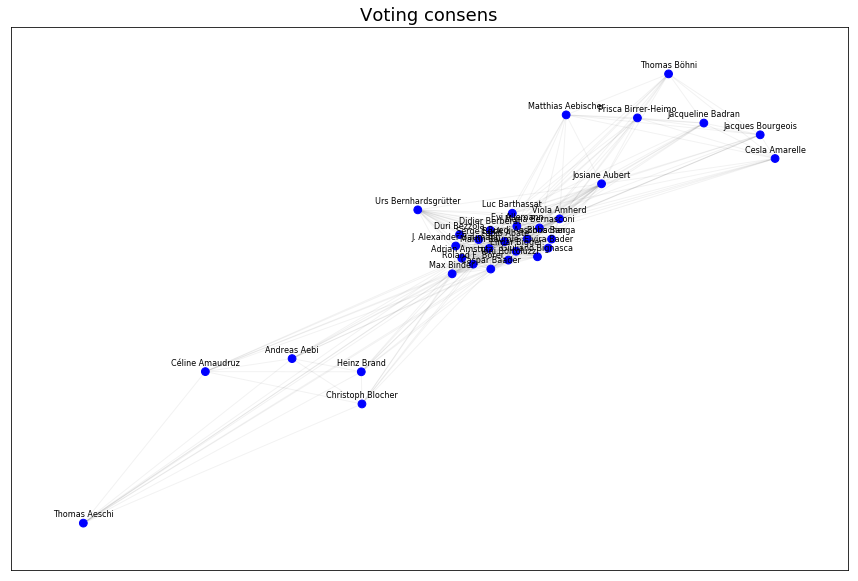

In [3]:
# plot should look the same every run
np.random.seed(1)

# get data
affairs = get_affairs()
councillors = get_councillors()
votes = get_votes_by_affair(affairs, True)

plt.figure(figsize=(15, 10))
graph = vote_graph(councillors, votes)
color = [graph.node[s]['color'] for s in graph.nodes()]

# determine position of each node
pos = nx.spring_layout(graph, iterations=200)

# plot edges and nodes
nx.draw_networkx_edges(graph, pos, alpha=0.05)
nx.draw_networkx_nodes(graph, pos, node_color=color, node_size=60)

# plot labels
for p in pos.values(): p[1] += .02
lbls = nx.draw_networkx_labels(graph, pos, alpha=5, font_size=8)

# other stuff
plt.title("Voting consens", fontsize=18)
plt.xticks([])
plt.yticks([])

plt.show()

In [4]:
# compute closeness centrality
bet = nx.closeness_centrality(graph, distance='difference')
bipart = sorted(bet, key=lambda x: -bet[x])

print(" ")
print("Highest closeness")
for s in bipart[:10]:
    print("%20.20s\t%0.3f" % (s, bet[s]))
print(" ")
print("Lowest closeness")
for s in bipart[-10:]:
    print("%20.20s\t%0.3f" % (s, bet[s]))

 
Highest closeness
        Evi Allemann	3.970
    Maria Bernasconi	3.967
      Adrian Amstutz	3.953
     Roland F. Borer	3.921
       Martin Bäumle	3.905
         Fabio Abate	3.892
     Didier Berberat	3.885
       Caspar Baader	3.881
        Elmar Bigger	3.870
          Serge Beck	3.854
 
Lowest closeness
   Jacques Bourgeois	1.538
      Cesla Amarelle	1.538
  Matthias Aebischer	1.538
 Prisca Birrer-Heimo	1.538
       Thomas Aeschi	1.489
         Heinz Brand	1.489
        Andreas Aebi	1.489
        Thomas Böhni	0.884
     Céline Amaudruz	0.879
   Christoph Blocher	0.879


### Todo / Fixes
* add dissens into weights
* add filters and comparisons
* write text and explain